# Sentiment Analysis Visualization

This notebook includes:
1. Word Cloud generation for different sentiment classes
2. Topic-Sentiment Heatmap to visualize the relationship between topics and sentiment

In [2]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 5.2 MB/s eta 0:00:000m eta -:--:--


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from collections import Counter
import ast
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

## Load Dataset

In [4]:
file_path = './labeled_data/labeled_sentiment.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2053, 4)


,full_text,tokens,processed_text,label
0,saya tidak setuju sama kurikulum obe yang terl...,"['tuju', 'kurikulum', 'obe', 'ikutin', 'butuh'...",tuju kurikulum obe ikutin butuh industri didik...,negatif
1,obe bikin saya sebagai guru jadi lebih banyak ...,"['obe', 'bikin', 'guru', 'ngurusin', 'dokumen'...",obe bikin guru ngurusin dokumen fokus ajar,negatif
2,demi obe kampus kami sampai ngabisin dana buat...,"['obe', 'kampus', 'ngabisin', 'dana', 'konsult...",obe kampus ngabisin dana konsultan dibutuhin b...,negatif
3,obe ini hanya jargon kosong di lapangan implem...,"['obe', 'jargon', 'kosong', 'lapang', 'impleme...",obe jargon kosong lapang implementasi amburadu...,negatif
4,garagara obe waktu buat penelitian jadi berkur...,"['garagara', 'obe', 'teliti', 'kurang', 'dosen...",garagara obe teliti kurang dosen sibuk bikin d...,negatif


## 1. Word Cloud Visualization

In [5]:
# Define Indonesian stopwords
indonesian_stopwords = set([
    'yang', 'di', 'dan', 'itu', 'dengan', 'untuk', 'tidak', 'ini', 'dari', 'dalam',
    'akan', 'pada', 'juga', 'saya', 'ke', 'bisa', 'ada', 'oleh', 'atau', 'tapi',
    'kita', 'aku', 'kepada', 'orang', 'ia', 'telah', 'bagi', 'mereka', 'dia', 'tak',
    'kamu', 'adalah', 'seperti', 'jika', 'ya', 'saat', 'agar', 'deh', 'si', 'nya'
]) | set(STOPWORDS)

# Function to convert token string to list
def parse_tokens(token_str):
    try:
        # Remove the outer brackets and split by commas
        # This is a simple parser for the token format in your dataset
        token_str = token_str.strip()[1:-1]  # Remove outer brackets
        tokens = [t.strip().strip('\'') for t in token_str.split(',')]
        return tokens
    except:
        return []

# Function to create word cloud
def create_wordcloud(text, title, stopwords=None, mask=None, max_words=100, background_color='white'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        max_words=max_words,
        stopwords=stopwords,
        background_color=background_color,
        colormap='viridis',
        mask=mask,
        contour_width=1,
        contour_color='steelblue',
        collocations=False  # Don't include bigrams
    ).generate_from_text(text)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, pad=20)
    plt.tight_layout()
    plt.show()

In [6]:
# Extract tokens for word cloud
df['token_list'] = df['tokens'].apply(parse_tokens)

# Separate tokens by sentiment
sentiment_texts = {}
for sentiment in df['label'].unique():
    # Filter rows by sentiment
    filtered_df = df[df['label'] == sentiment]
    
    # Collect all tokens for this sentiment
    all_tokens = []
    for tokens in filtered_df['token_list']:
        all_tokens.extend(tokens)
    
    # Join tokens into a single text for word cloud
    sentiment_texts[sentiment] = ' '.join(all_tokens)

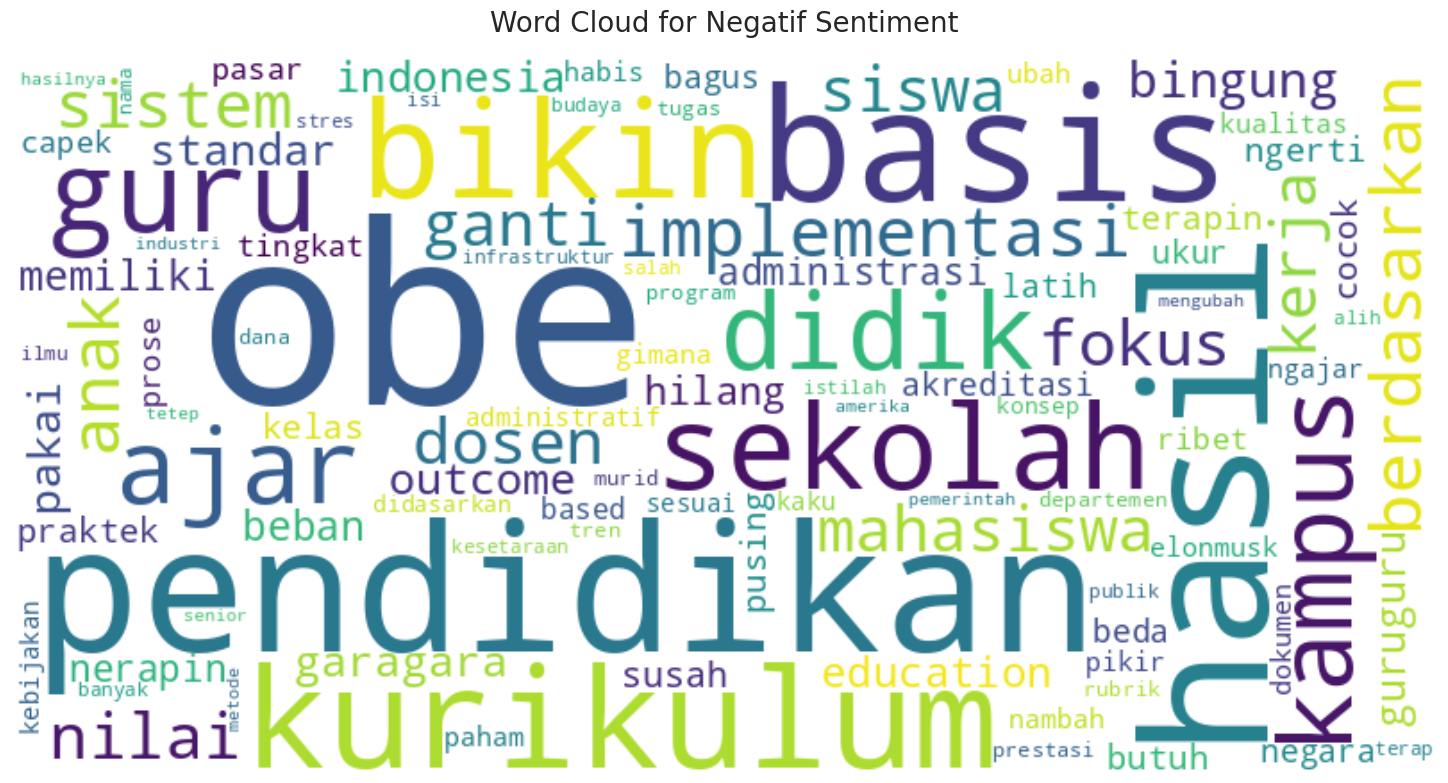

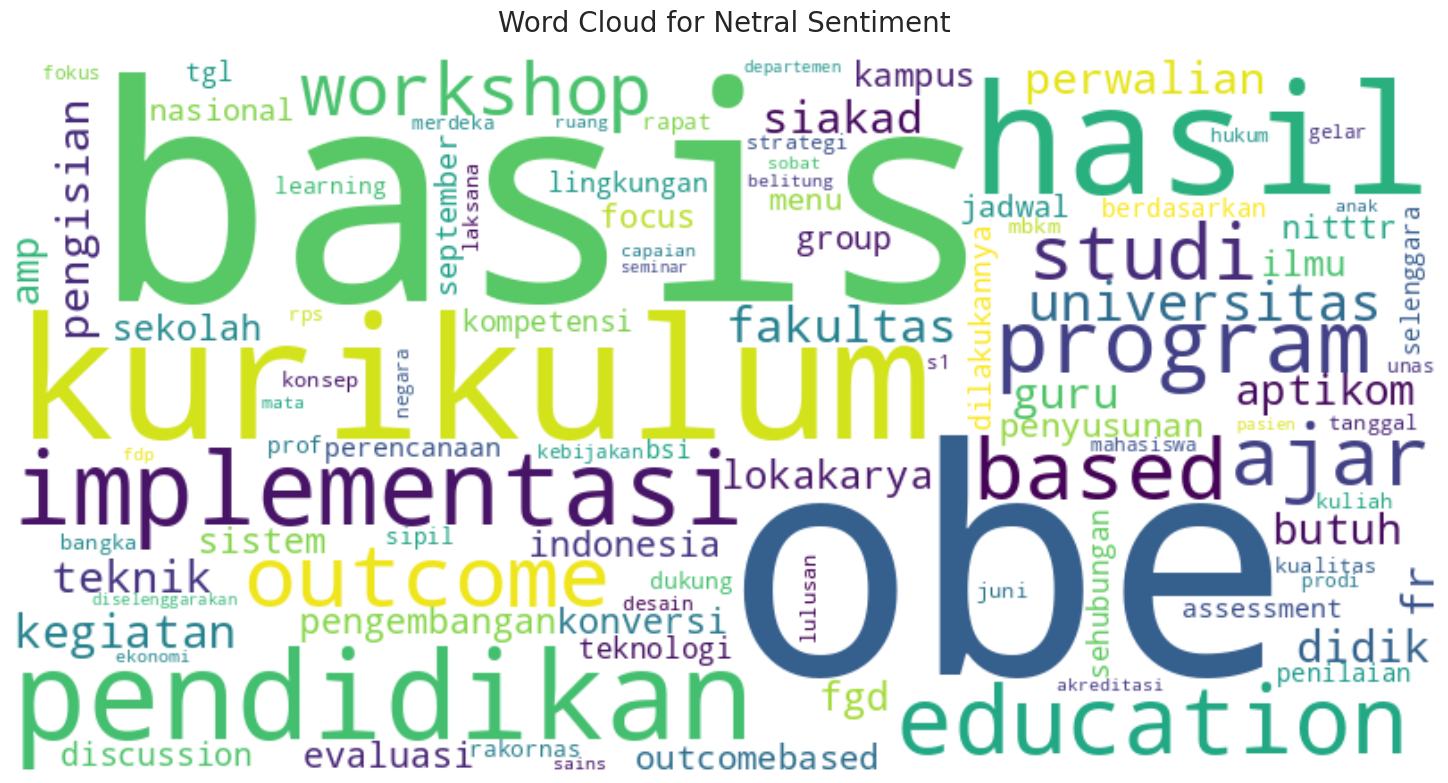

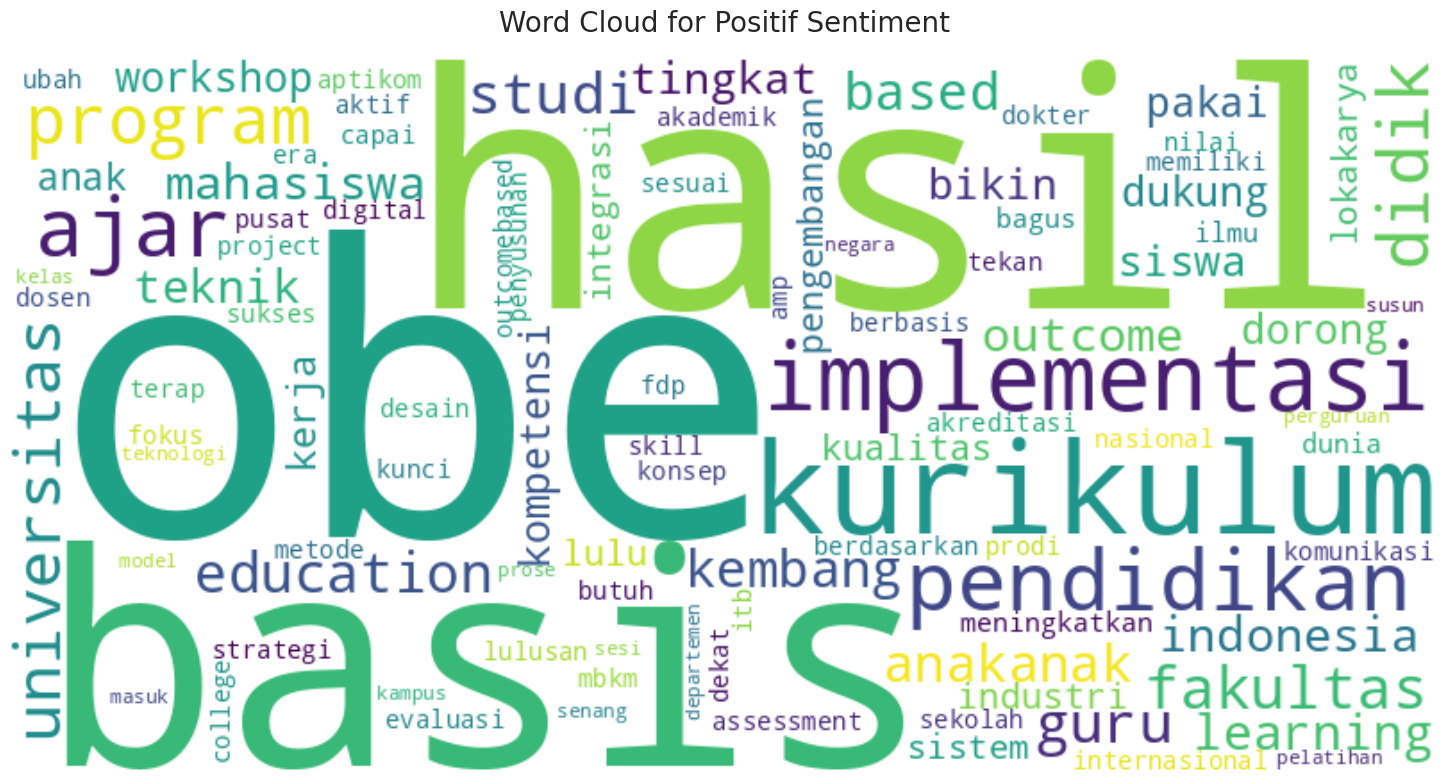

In [7]:
# Create word clouds for each sentiment
for sentiment, text in sentiment_texts.items():
    if text.strip():  # Check if there's text to process
        create_wordcloud(
            text, 
            f'Word Cloud for {sentiment.capitalize()} Sentiment', 
            stopwords=indonesian_stopwords
        )

## 2. Combined Word Cloud with Different Colors for Each Sentiment

In [8]:
# Create a DataFrame with word frequencies per sentiment
word_freq = {}

for sentiment in df['label'].unique():
    # Get tokens for this sentiment
    tokens = []
    for token_list in df[df['label'] == sentiment]['token_list']:
        tokens.extend(token_list)
    
    # Count frequencies
    counter = Counter(tokens)
    
    # Remove stopwords
    for word in list(counter.keys()):
        if word.lower() in indonesian_stopwords or len(word) < 3:
            del counter[word]
    
    word_freq[sentiment] = counter

# Get unique words across all sentiments
all_words = set()
for counter in word_freq.values():
    all_words.update(counter.keys())

# Create DataFrame
rows = []
for word in all_words:
    row = {'word': word}
    for sentiment in word_freq.keys():
        row[sentiment] = word_freq[sentiment].get(word, 0)
    rows.append(row)

word_df = pd.DataFrame(rows)

# Show the DataFrame
print(f"Word frequency DataFrame shape: {word_df.shape}")
word_df.head()

Word frequency DataFrame shape: (5613, 4)


,word,negatif,netral,positif
0,transparansi,0,0,1
1,session,0,1,0
2,bahanbahan,0,0,1
3,inisiatif,0,0,2
4,libertarianlars,0,0,1


## 3. Topic-Sentiment Heatmap

In [9]:
# Extract the most frequent words overall (potential topics)
all_counts = pd.Series(dtype='int64')
for sentiment in df['label'].unique():
    all_counts = all_counts.add(word_df[sentiment], fill_value=0)
    
word_df['total'] = all_counts
top_words = word_df.sort_values('total', ascending=False).head(30)['word'].tolist()

# Create heatmap data
heatmap_data = []
for word in top_words:
    row = {'word': word}
    word_row = word_df[word_df['word'] == word].iloc[0]
    total = word_row['total']
    for sentiment in df['label'].unique():
        # Calculate percentage for each sentiment
        if total > 0:
            row[sentiment] = word_row[sentiment] / total * 100
        else:
            row[sentiment] = 0
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data)
heatmap_df.head()

,word,negatif,netral,positif
0,obe,37.285364,21.177433,41.537204
1,basis,16.783217,27.855478,55.361305
2,hasil,21.236873,20.303384,58.459743
3,kurikulum,17.125382,33.027523,49.847095
4,pendidikan,35.283019,24.716981,40.000000


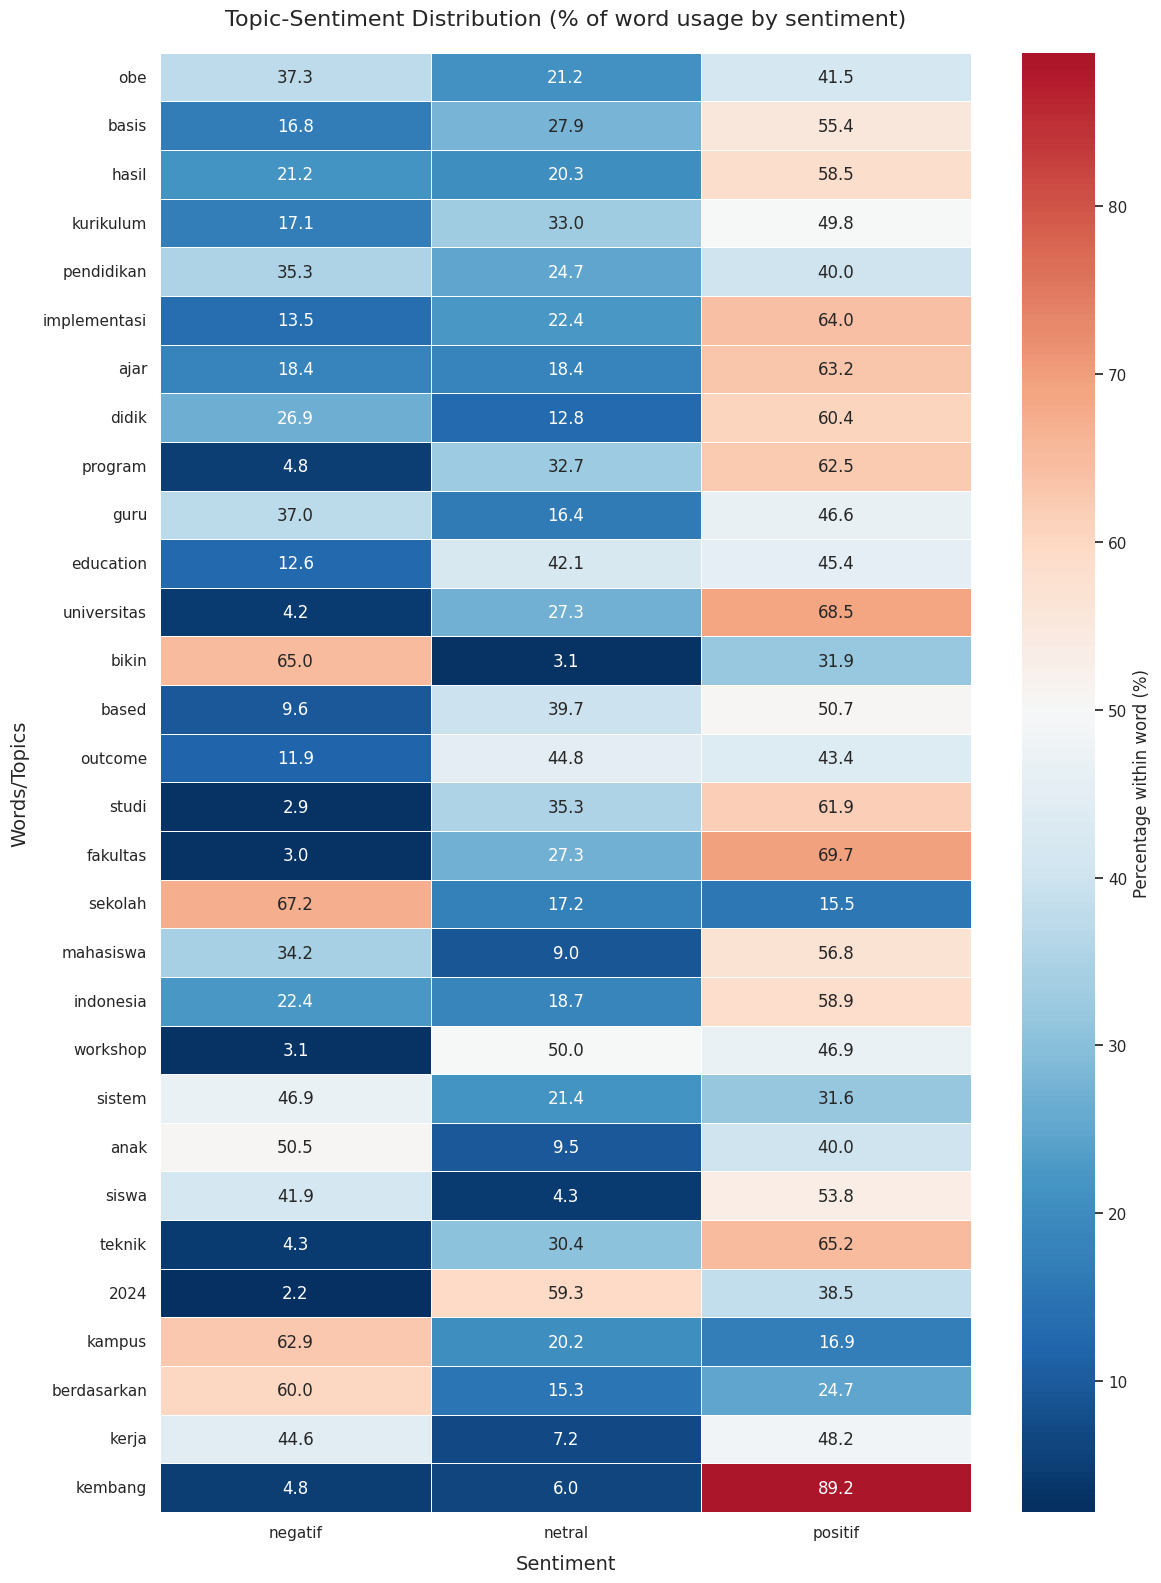

In [10]:
# Create heatmap showing word-sentiment relationships
plt.figure(figsize=(12, 16))

# Set up the data for the heatmap
heatmap_matrix = heatmap_df.set_index('word')[df['label'].unique()].values
words = heatmap_df['word'].tolist()

# Create heatmap
ax = sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt='.1f',
    cmap='RdBu_r',
    center=50,
    linewidths=.5,
    yticklabels=words,
    xticklabels=df['label'].unique(),
    cbar_kws={'label': 'Percentage within word (%)'}
)

plt.title('Topic-Sentiment Distribution (% of word usage by sentiment)', fontsize=16, pad=20)
plt.xlabel('Sentiment', fontsize=14, labelpad=10)
plt.ylabel('Words/Topics', fontsize=14, labelpad=10)
plt.tight_layout()
plt.show()

## 4. Absolute Frequency Heatmap

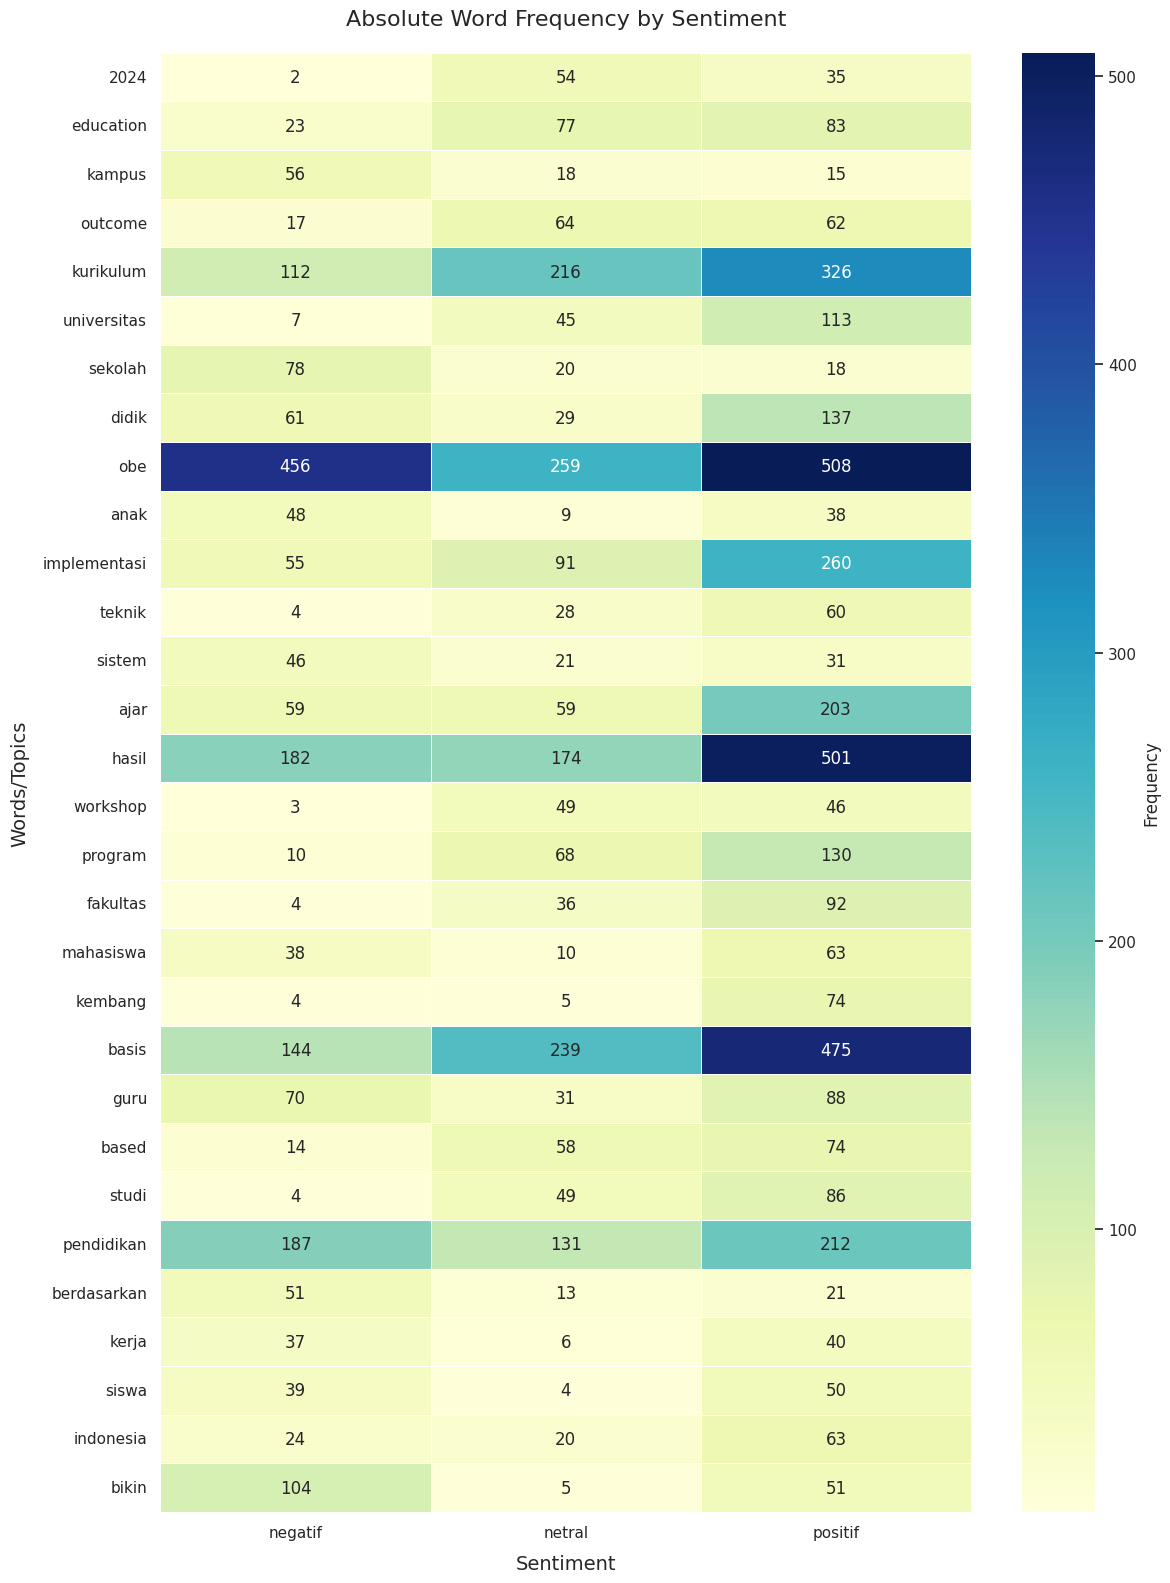

In [11]:
# Create an absolute frequency heatmap
absolute_heatmap_df = word_df[word_df['word'].isin(top_words)].copy()
absolute_heatmap_df = absolute_heatmap_df[['word'] + list(df['label'].unique())]

plt.figure(figsize=(12, 16))

# Set up the data for the heatmap
abs_heatmap_matrix = absolute_heatmap_df.set_index('word')[df['label'].unique()].values
words = absolute_heatmap_df['word'].tolist()

# Create heatmap
ax = sns.heatmap(
    abs_heatmap_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=.5,
    yticklabels=words,
    xticklabels=df['label'].unique(),
    cbar_kws={'label': 'Frequency'}
)

plt.title('Absolute Word Frequency by Sentiment', fontsize=16, pad=20)
plt.xlabel('Sentiment', fontsize=14, labelpad=10)
plt.ylabel('Words/Topics', fontsize=14, labelpad=10)
plt.tight_layout()
plt.show()

## 5. Topic Extraction with TF-IDF

In [12]:
# Function to extract important terms for each sentiment using TF-IDF
def extract_important_terms(df, label_column, text_column, n_terms=10):
    results = {}
    
    for sentiment in df[label_column].unique():
        # Get text for this sentiment
        sentiment_texts = df[df[label_column] == sentiment][text_column].tolist()
        
        # Create TF-IDF vectorizer
        tfidf = TfidfVectorizer(
            min_df=2,
            max_df=0.95,
            max_features=1000,
            stop_words=list(indonesian_stopwords)
        )
        
        # Transform text to TF-IDF matrix
        tfidf_matrix = tfidf.fit_transform(sentiment_texts)
        
        # Get feature names
        feature_names = tfidf.get_feature_names_out()
        
        # Calculate mean TF-IDF for each term
        mean_tfidf = tfidf_matrix.mean(axis=0).A1
        
        # Get top terms
        top_indices = mean_tfidf.argsort()[-n_terms:][::-1]
        top_terms = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
        
        results[sentiment] = top_terms
    
    return results

# Extract important terms for each sentiment
important_terms = extract_important_terms(df, 'label', 'full_text', n_terms=20)

# Display important terms
for sentiment, terms in important_terms.items():
    print(f"\nTop terms for {sentiment} sentiment:")
    for term, score in terms:
        print(f"{term}: {score:.4f}")


Top terms for negatif sentiment:
obe: 0.0744
pendidikan: 0.0448
bikin: 0.0357
hasil: 0.0356
kurikulum: 0.0337
sama: 0.0322
jadi: 0.0320
berbasis: 0.0320
hanya: 0.0302
guru: 0.0279
saja: 0.0273
banyak: 0.0249
sekolah: 0.0238
terlalu: 0.0223
buat: 0.0221
masih: 0.0221
kami: 0.0220
malah: 0.0214
semua: 0.0211
kampus: 0.0190

Top terms for netral sentiment:
berbasis: 0.0666
hasil: 0.0613
obe: 0.0602
pendidikan: 0.0584
kurikulum: 0.0546
implementasi: 0.0327
outcome: 0.0265
education: 0.0264
tentang: 0.0261
program: 0.0254
based: 0.0239
workshop: 0.0209
studi: 0.0193
2024: 0.0181
tinggi: 0.0180
universitas: 0.0178
pembelajaran: 0.0175
sama: 0.0171
saja: 0.0162
perguruan: 0.0157

Top terms for positif sentiment:
obe: 0.0632
hasil: 0.0592
berbasis: 0.0589
pendidikan: 0.0501
kurikulum: 0.0493
lebih: 0.0399
implementasi: 0.0390
tinggi: 0.0271
anakanak: 0.0261
pembelajaran: 0.0260
program: 0.0250
jadi: 0.0243
universitas: 0.0230
perguruan: 0.0221
studi: 0.0202
fakultas: 0.0188
learning: 0.0185
m

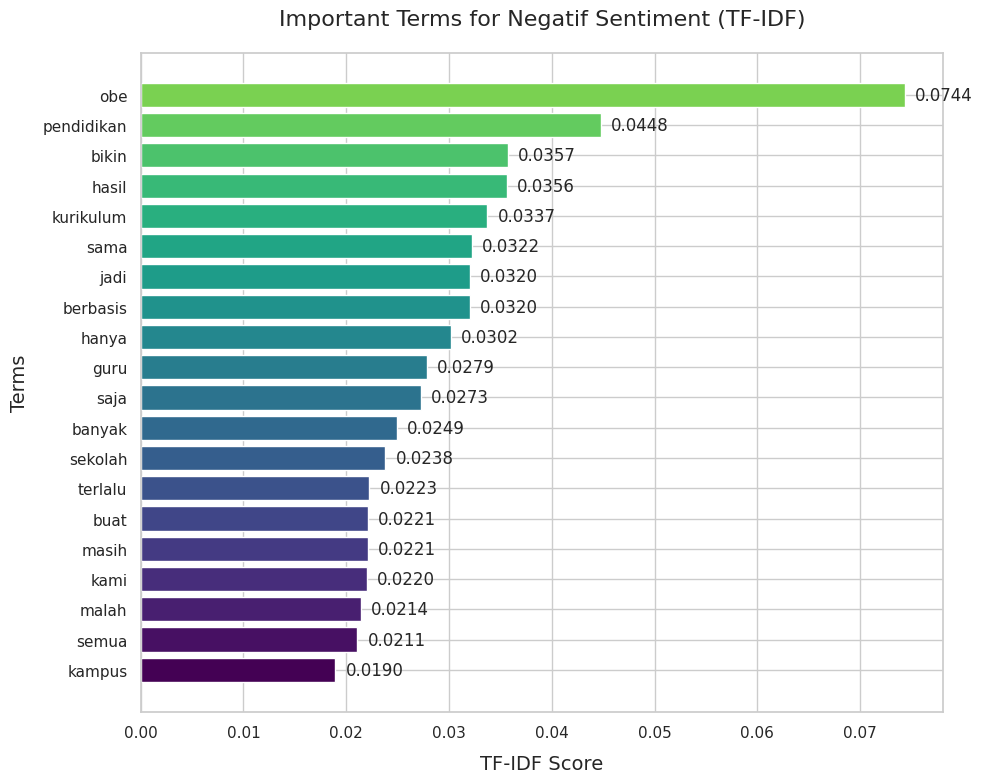

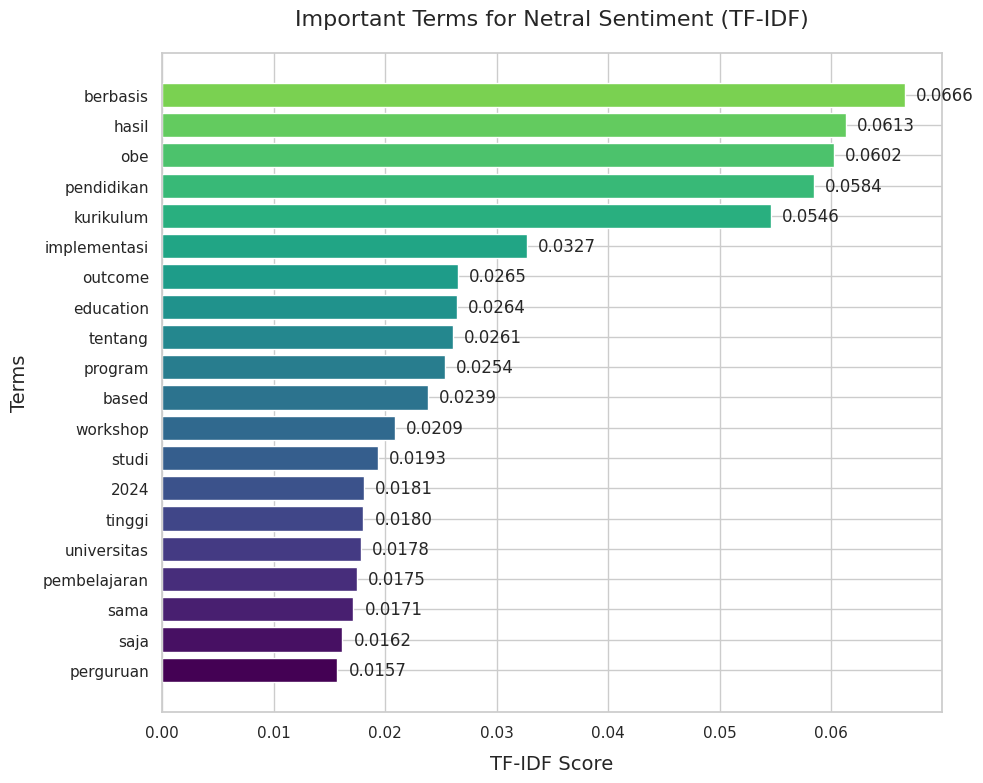

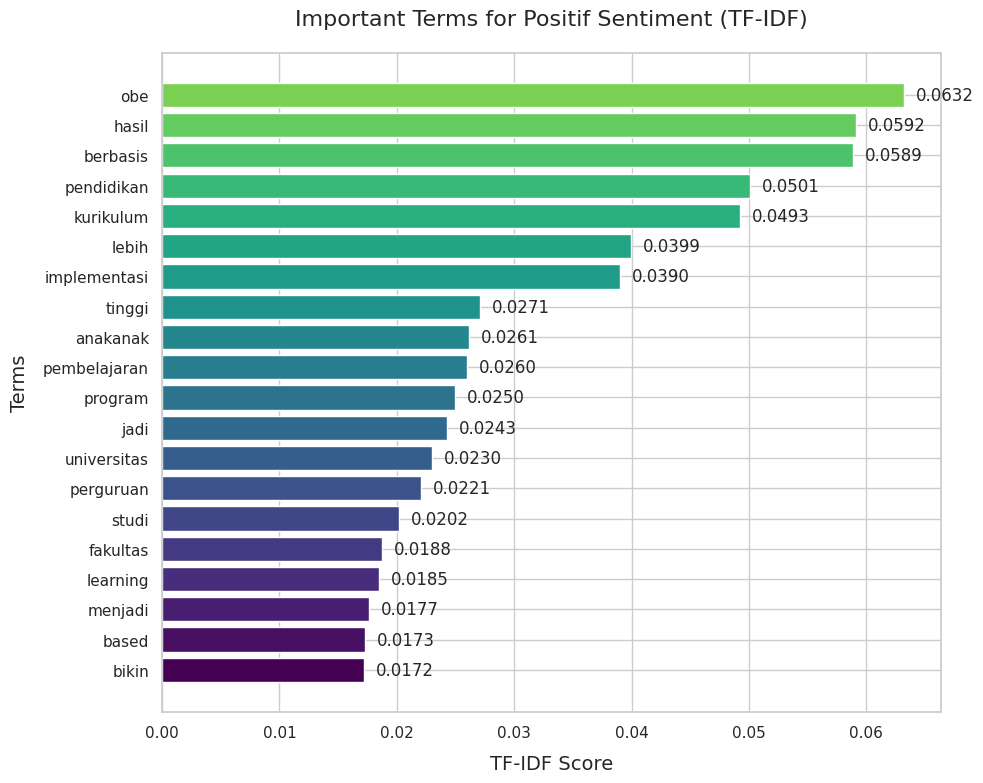

In [13]:
# Create horizontal bar chart for important terms by sentiment
for sentiment, terms in important_terms.items():
    plt.figure(figsize=(10, 8))
    
    # Extract terms and scores
    terms_list = [term for term, _ in terms]
    scores = [score for _, score in terms]
    
    # Create horizontal bar chart
    bars = plt.barh(terms_list[::-1], scores[::-1], color=plt.cm.viridis(np.linspace(0, 0.8, len(terms))))
    
    # Add score labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                 f"{scores[::-1][i]:.4f}", va='center')
    
    plt.title(f'Important Terms for {sentiment.capitalize()} Sentiment (TF-IDF)', fontsize=16, pad=20)
    plt.xlabel('TF-IDF Score', fontsize=14, labelpad=10)
    plt.ylabel('Terms', fontsize=14, labelpad=10)
    plt.tight_layout()
    plt.show()

## 6. Correlation Heatmap of Word Co-occurrences

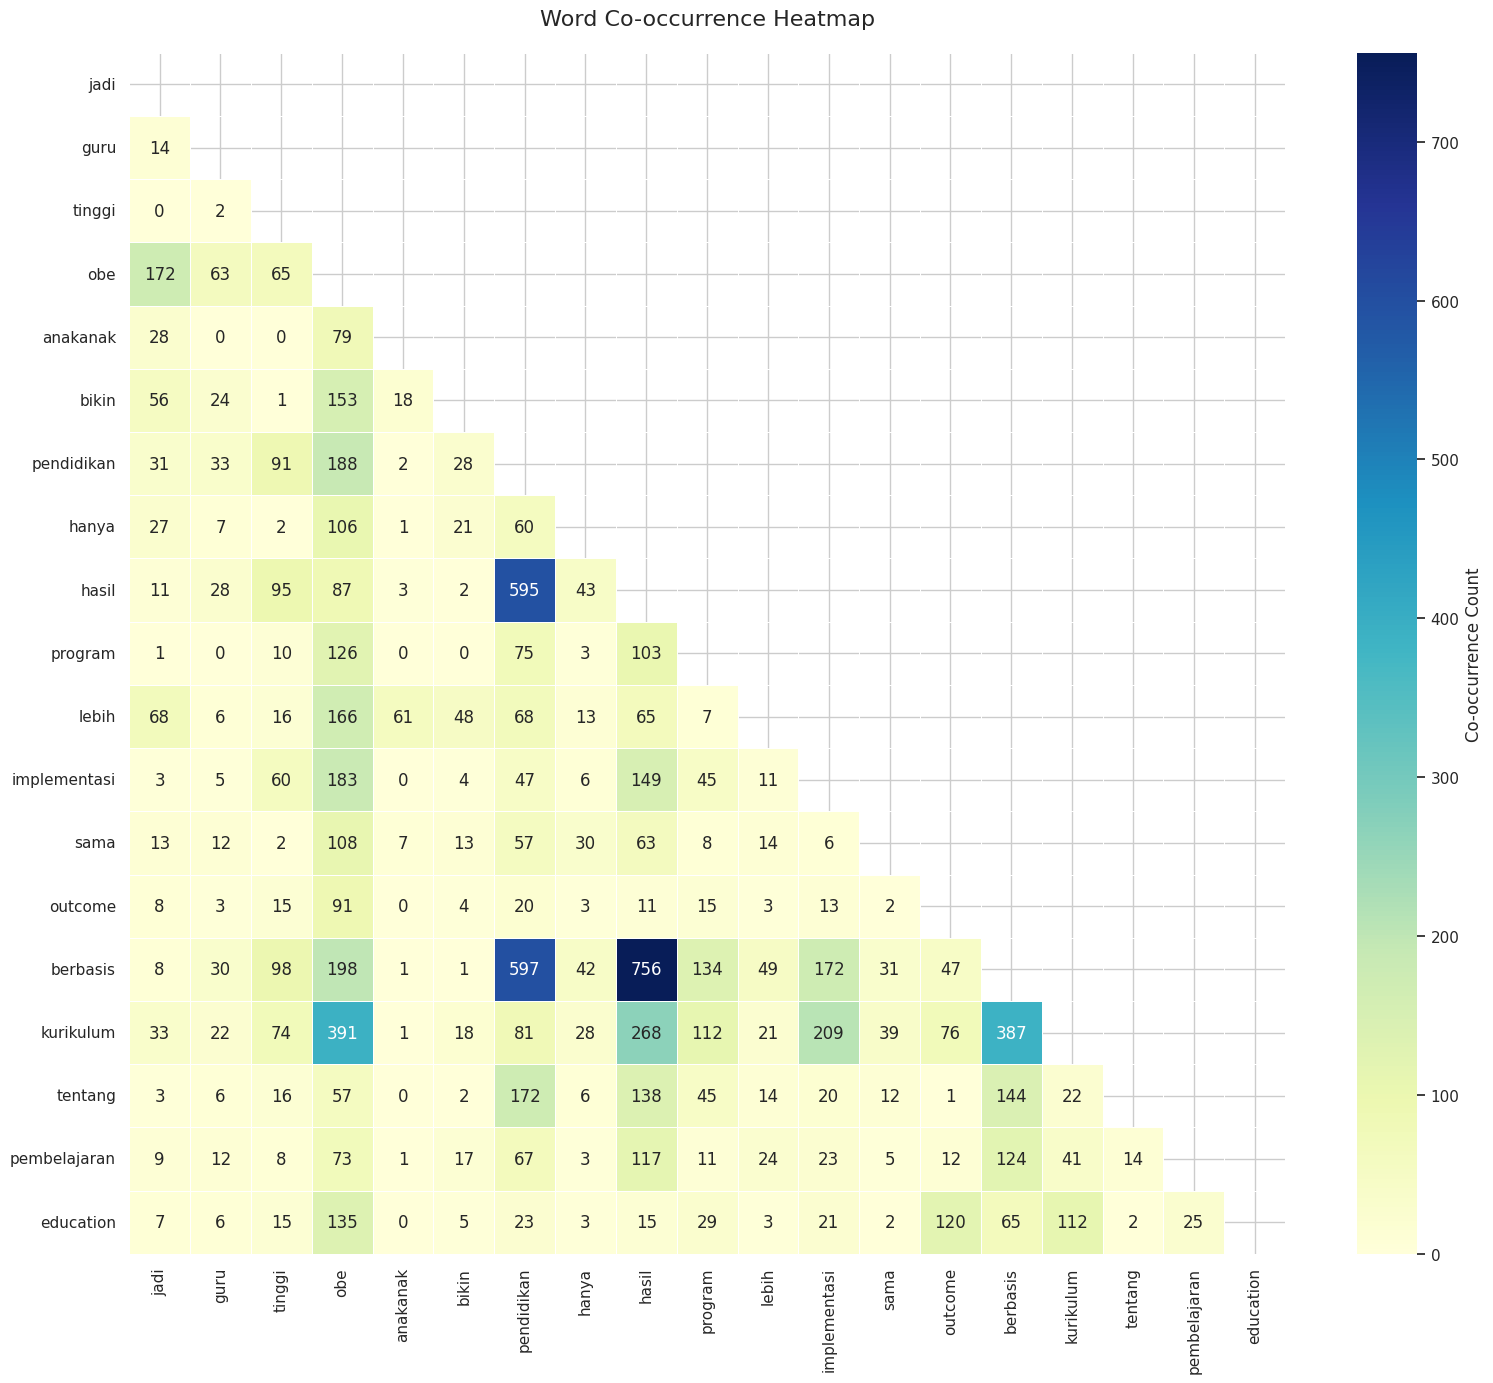

In [14]:
# Identify top words across all sentiments
all_top_words = set()
for sentiment, terms in important_terms.items():
    for term, _ in terms[:10]:  # Take top 10 from each sentiment
        all_top_words.add(term)
all_top_words = list(all_top_words)

# Create CountVectorizer to count word co-occurrences
count_vectorizer = CountVectorizer(vocabulary=all_top_words)
count_matrix = count_vectorizer.fit_transform(df['full_text'])

# Convert to co-occurrence matrix
co_occurrence_matrix = (count_matrix.T @ count_matrix).toarray()

# Set diagonal to 0 to avoid self-correlations
np.fill_diagonal(co_occurrence_matrix, 0)

# Create DataFrame for heatmap
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=all_top_words, columns=all_top_words)

# Plot co-occurrence heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))
sns.heatmap(
    co_occurrence_df,
    cmap='YlGnBu',
    mask=mask,
    annot=True,
    fmt='d',
    linewidths=.5,
    cbar_kws={'label': 'Co-occurrence Count'}
)
plt.title('Word Co-occurrence Heatmap', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## 7. Sentiment-specific n-grams Analysis

In [15]:
# Function to extract top n-grams for each sentiment
def extract_ngrams(df, label_column, text_column, n=2, top_n=10):
    results = {}
    
    for sentiment in df[label_column].unique():
        # Get text for this sentiment
        sentiment_texts = df[df[label_column] == sentiment][text_column].tolist()
        
        # Create n-gram vectorizer
        ngram_vectorizer = CountVectorizer(
            ngram_range=(n, n),
            min_df=2,
            stop_words=list(indonesian_stopwords)
        )
        
        # Transform text to n-gram counts
        try:
            ngram_matrix = ngram_vectorizer.fit_transform(sentiment_texts)
            
            # Get feature names
            feature_names = ngram_vectorizer.get_feature_names_out()
            
            # Calculate total counts for each n-gram
            ngram_counts = ngram_matrix.sum(axis=0).A1
            
            # Get top n-grams
            top_indices = ngram_counts.argsort()[-top_n:][::-1]
            top_ngrams = [(feature_names[i], ngram_counts[i]) for i in top_indices]
            
            results[sentiment] = top_ngrams
        except:
            results[sentiment] = []
    
    return results

# Extract bigrams for each sentiment
top_bigrams = extract_ngrams(df, 'label', 'full_text', n=2, top_n=15)

# Display top bigrams
for sentiment, ngrams in top_bigrams.items():
    print(f"\nTop bigrams for {sentiment} sentiment:")
    for ngram, count in ngrams:
        print(f"{ngram}: {count}")


Top bigrams for negatif sentiment:
pendidikan berbasis: 90
berbasis hasil: 89
malah bikin: 39
obe bikin: 38
kurikulum obe: 34
kampus kami: 32
obe malah: 30
obe hanya: 28
implementasi obe: 27
terlalu banyak: 19
bikin pendidikan: 19
garagara obe: 18
nerapin obe: 18
pendidikan jadi: 17
obe terlalu: 17

Top bigrams for netral sentiment:
berbasis hasil: 130
pendidikan berbasis: 88
kurikulum berbasis: 85
kurikulum obe: 65
based education: 57
outcome based: 56
education obe: 55
implementasi kurikulum: 51
program studi: 42
perwalian pengisian: 29
berbasis obe: 29
pengisian frs: 29
perguruan tinggi: 24
workshop kurikulum: 23
tentang pendidikan: 23

Top bigrams for positif sentiment:
berbasis hasil: 405
kurikulum berbasis: 219
pendidikan berbasis: 195
implementasi kurikulum: 131
perguruan tinggi: 81
program studi: 77
implementasi obe: 59
jadi lebih: 55
kurikulum obe: 47
tentang pendidikan: 46
based education: 46
outcome based: 43
obe bikin: 43
education obe: 43
pakai obe: 37


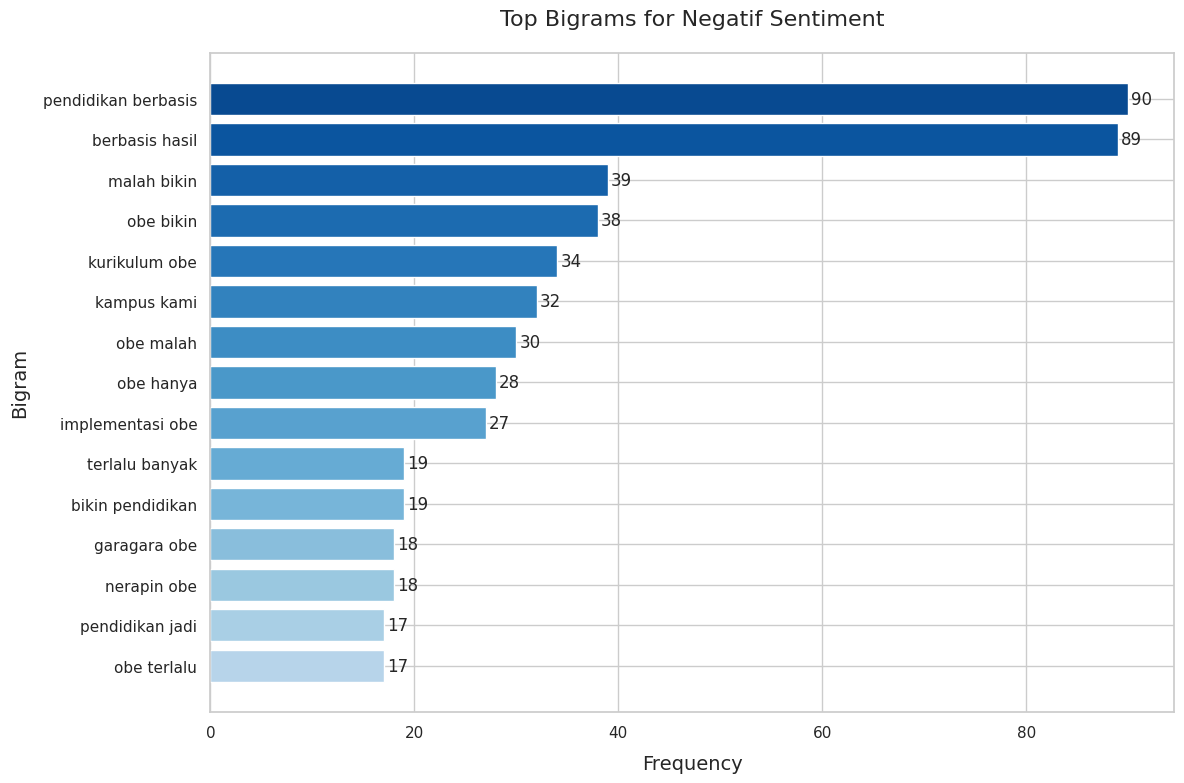

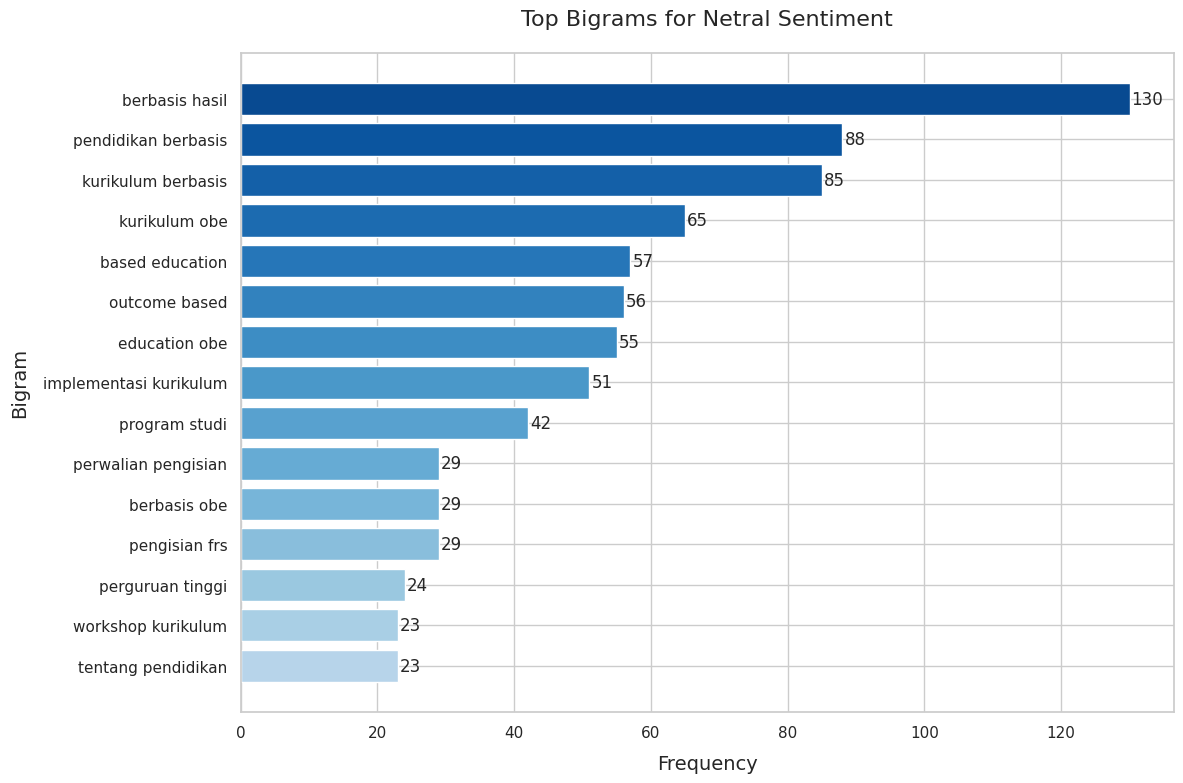

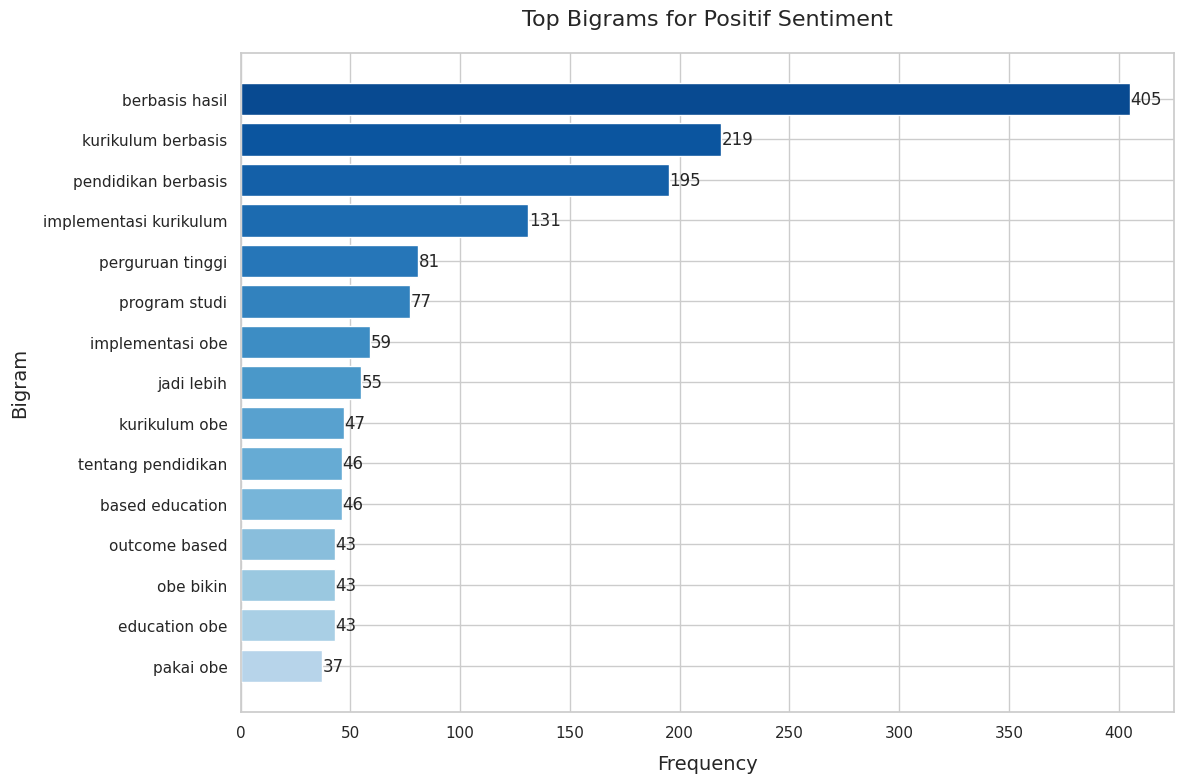

In [16]:
# Plot top bigrams for each sentiment
for sentiment, ngrams in top_bigrams.items():
    if ngrams:  # Check if there are bigrams to display
        plt.figure(figsize=(12, 8))
        
        # Extract terms and counts
        ngram_list = [ngram for ngram, _ in ngrams]
        counts = [count for _, count in ngrams]
        
        # Create horizontal bar chart
        bars = plt.barh(ngram_list[::-1], counts[::-1], color=plt.cm.Blues(np.linspace(0.3, 0.9, len(ngrams))))
        
        # Add count labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
                     f"{counts[::-1][i]}", va='center')
        
        plt.title(f'Top Bigrams for {sentiment.capitalize()} Sentiment', fontsize=16, pad=20)
        plt.xlabel('Frequency', fontsize=14, labelpad=10)
        plt.ylabel('Bigram', fontsize=14, labelpad=10)
        plt.tight_layout()
        plt.show()